1. Make a binary classification dataset with Scikit-Learn's `make_moons()` function.
    * For consistency, the dataset should have 1000 samples and a `random_state=42` .
    * Turn the data into PyTorch tensors. Split the data into training and test sets using `train_test_split` with 80% training and 20% testing.

In [1]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import torch
import torchmetrics
from torch import nn

In [2]:
X, y = make_moons(n_samples=1000, shuffle= True, random_state= 42)
X, y = torch.from_numpy(X).type(torch.float), torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
len(X_train), len(X_test)

(800, 200)

2. Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
    * Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_features, output_features, hidden_units= 8):
        '''Binary Classification Model
        Args: 
            input_features (int): Number of features the model takes.
            output_features (int): Number of features the model returns.
            hidden_units (int): Number of hidden units the layers have, default value 8. '''
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)
    
model_0 = BinaryClassifier(input_features=2, output_features=1, hidden_units= 1024).to(device)

model_0.state_dict()

OrderedDict([('linear_layer_stack.0.weight',
              tensor([[ 0.0698,  0.0071],
                      [ 0.3390, -0.2217],
                      [ 0.6713,  0.5748],
                      ...,
                      [-0.2495, -0.4322],
                      [-0.2985,  0.3360],
                      [-0.4252, -0.6578]], device='cuda:0')),
             ('linear_layer_stack.0.bias',
              tensor([ 0.3115, -0.5625,  0.6950,  ..., -0.4588,  0.1376,  0.2487],
                     device='cuda:0')),
             ('linear_layer_stack.2.weight',
              tensor([[ 0.0061, -0.0197,  0.0139,  ..., -0.0208,  0.0221, -0.0304],
                      [ 0.0167, -0.0096, -0.0055,  ..., -0.0271,  0.0109, -0.0023],
                      [-0.0232,  0.0289, -0.0037,  ..., -0.0275, -0.0210, -0.0094],
                      ...,
                      [-0.0185, -0.0052,  0.0249,  ..., -0.0233, -0.0118, -0.0256],
                      [ 0.0130,  0.0282,  0.0198,  ..., -0.0067, -0.0290,  0.0123]

3. Setup a binary classification compatible loss function and optimizer to use when training the model.

In [6]:
# loss function
loss_fn = nn.BCEWithLogitsLoss()
# Optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)
# Accuracy function
accuracy_fn = torchmetrics.Accuracy(task='binary').to(device)

4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
    * To measure model accuray, you can create your own accuracy function or use the accuracy function in TorchMetrics.
    * Train the model for long enough for it to reach over 96% accuracy.
    * The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [7]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

# Making sure the tensors and model is on the same device
X_train, X_test = X_train.to(device), X_test.to(device) 
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training ###
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    # 2. loss and accuracy calculations
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_preds, y_train)

    # 3. optimizer zero gradient
    optimizer.zero_grad()

    # 4. loss backwards
    loss.backward()

    # 5. optimizer step
    optimizer.step()

    ### Testing ###
    model_0.eval()

    with torch.inference_mode():
        # Forward pass
        test_logits= model_0(X_test).squeeze()
        test_pred= torch.round(torch.sigmoid(test_logits))

        # Loss and accuracy calculation
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(test_pred, y_test)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f}, Test Loss: {test_loss:.4f} | Acc: {100*acc:.2f}%, Test Acc: {100*test_acc:.2f}%")

Epoch: 0 | Loss: 0.6812, Test Loss: 0.6474 | Acc: 50.00%, Test Acc: 80.00%
Epoch: 10 | Loss: 0.3715, Test Loss: 0.3684 | Acc: 84.50%, Test Acc: 85.00%
Epoch: 20 | Loss: 0.2559, Test Loss: 0.2584 | Acc: 87.50%, Test Acc: 89.50%
Epoch: 30 | Loss: 0.2099, Test Loss: 0.2096 | Acc: 90.25%, Test Acc: 91.50%
Epoch: 40 | Loss: 0.1792, Test Loss: 0.1780 | Acc: 92.00%, Test Acc: 93.00%
Epoch: 50 | Loss: 0.1526, Test Loss: 0.1511 | Acc: 93.50%, Test Acc: 94.00%
Epoch: 60 | Loss: 0.1274, Test Loss: 0.1253 | Acc: 95.00%, Test Acc: 95.00%
Epoch: 70 | Loss: 0.1431, Test Loss: 0.1336 | Acc: 94.75%, Test Acc: 94.50%
Epoch: 80 | Loss: 0.0977, Test Loss: 0.0850 | Acc: 96.25%, Test Acc: 97.50%
Epoch: 90 | Loss: 0.0741, Test Loss: 0.0678 | Acc: 97.62%, Test Acc: 99.50%


5. Make predictions with your trained model and plot them using the `plot_decision_boundary()` function created in this notebook.

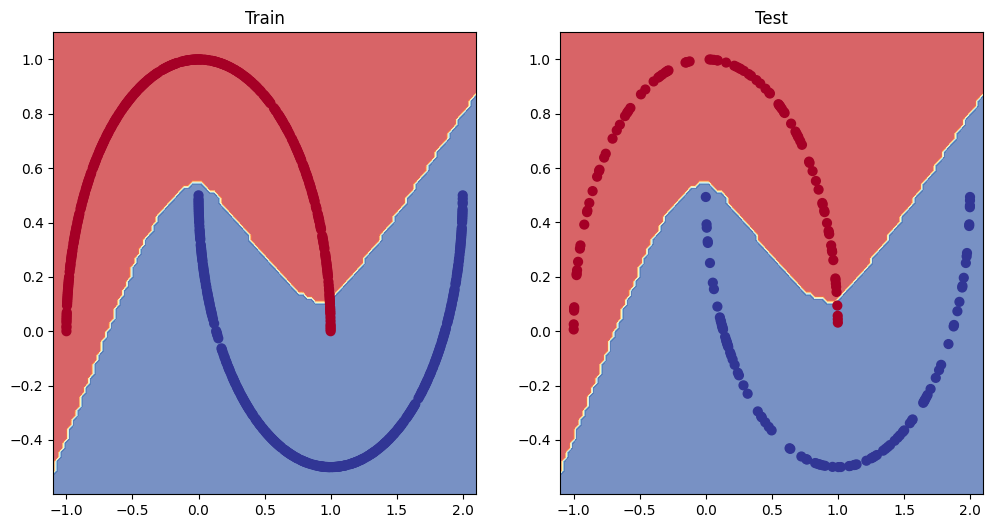

In [8]:
from helper_functions import plot_decision_boundary
import matplotlib.pyplot as plt 

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.

In [9]:
m = nn.Tanh()
input = torch.randn(10000)
output = m(input)

Text(0.5, 1.0, 'Tanh Function Using PyTorch')

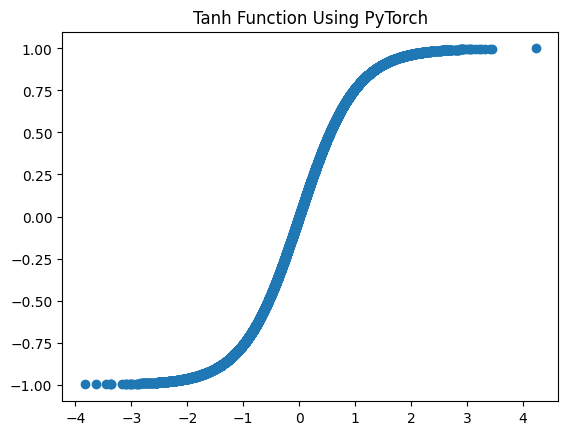

In [10]:
plt.scatter(x= input, y=output)
plt.title("Tanh Function Using PyTorch")

7. Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).
    * Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
    * Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
    * Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like).
    * Plot the decision boundaries on the spirals dataset from your model predictions, the plot_decision_boundary() function should work for this dataset too.

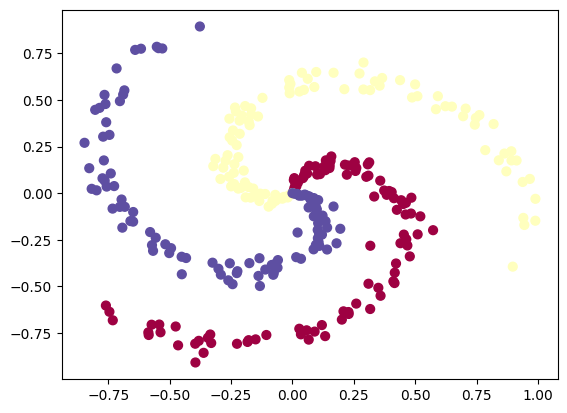

In [11]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [12]:
from pathlib import Path

MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents= True, exist_ok= True)

MODEL_NAME ='02_BinaryClassifier_model_0.pth'
SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving Model state_dict() t0:{SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=SAVE_PATH)


Saving Model state_dict() t0:models\02_BinaryClassifier_model_0.pth


In [13]:
class MultiClassClassifier(nn.Module):
    def __init__(self, input_features, output_features, hidden_units= 8) -> None:
        '''A multiclass classifier that can sort the data above.
        Args:
            input_features (int): Number of features the model takes.
            output_features (int): Number of features the model returns.
            hidden_units (int): Number of hidden units the layers have, default value 8. 
        '''
        super().__init__()
        self.linear_layer_stack= nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU6(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU6(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU6(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU6(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)
    
model_1 = MultiClassClassifier(input_features=2, output_features=4, hidden_units=512).to(device)

In [14]:
# Loss and Accuracy Functions
loss_fn = nn.CrossEntropyLoss()
accuracy_fn= torchmetrics.Accuracy(task='multiclass', num_classes=4).to(device)
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [15]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

In [16]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

In [17]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs= 1000

for epoch in range(epochs):
    ### Training ###
    model_1.train()

    # 1. Forward pass
    y_logits= model_1(X_train)
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # 2. Loss and Accuracy calculations
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_preds, y_train)

    # 3. Optimizer Zero Grad
    optimizer.zero_grad()

    # 4. loss backwards
    loss.backward()

    # 5. optimizer step
    optimizer.step()

    ### Testing ###
    model_1.eval()

    with torch.inference_mode():
    # Forward pass
        test_logits = model_1(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        # Loss and Accuracy Calculations
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(test_pred, y_test)

        if epoch % 10 == 0:
            print(f'Epoch: {epoch} | Loss: {loss:.4f}, Accuracy: {100*acc:.2f}% | Test Loss: {test_loss:.4f}, Test Accuracy: {100*test_acc:.2f}%')

Epoch: 0 | Loss: 1.3798, Accuracy: 32.50% | Test Loss: 1.3559, Test Accuracy: 36.67%
Epoch: 10 | Loss: 1.2302, Accuracy: 50.83% | Test Loss: 1.2210, Test Accuracy: 53.33%
Epoch: 20 | Loss: 1.1168, Accuracy: 59.58% | Test Loss: 1.1169, Test Accuracy: 53.33%
Epoch: 30 | Loss: 1.0250, Accuracy: 58.33% | Test Loss: 1.0301, Test Accuracy: 55.00%
Epoch: 40 | Loss: 0.9243, Accuracy: 55.00% | Test Loss: 0.9305, Test Accuracy: 50.00%
Epoch: 50 | Loss: 0.8221, Accuracy: 53.33% | Test Loss: 0.8282, Test Accuracy: 50.00%
Epoch: 60 | Loss: 0.7430, Accuracy: 56.67% | Test Loss: 0.7581, Test Accuracy: 55.00%
Epoch: 70 | Loss: 0.7388, Accuracy: 60.42% | Test Loss: 0.7437, Test Accuracy: 58.33%
Epoch: 80 | Loss: 0.7168, Accuracy: 64.58% | Test Loss: 0.7879, Test Accuracy: 66.67%
Epoch: 90 | Loss: 0.6621, Accuracy: 65.83% | Test Loss: 0.6757, Test Accuracy: 66.67%
Epoch: 100 | Loss: 0.7258, Accuracy: 64.17% | Test Loss: 0.7302, Test Accuracy: 65.00%
Epoch: 110 | Loss: 0.6753, Accuracy: 67.92% | Test Los

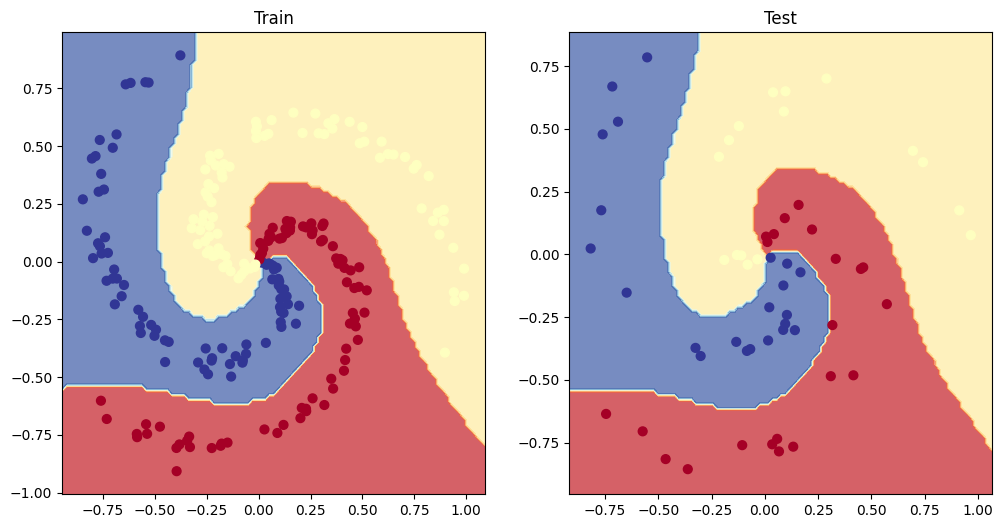

In [18]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [19]:
from pathlib import Path

MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents= True, exist_ok= True)

MODEL_NAME ='02_MultiClassClassifier_model_0.pth'
SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving Model state_dict() t0:{SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f=SAVE_PATH)


Saving Model state_dict() t0:models\02_MultiClassClassifier_model_0.pth
